In [23]:
from examples.gpt4v.instruct import system_prompt
from examples.gpt4v.oai import chat
from examples.gpt4v.util import visualize_b64_img
from agentdesk import Desktop

ImportError: cannot import name 'visualize_b64_img' from 'examples.gpt4v.util' (/Users/patrickbarker/ghq/github.com/agentsea/agent-desk/examples/gpt4v/util.py)

In [2]:
task = "Search for types of Canadian ducks"

In [ ]:
# Create a local desktop
desktop = Desktop.local()

In [3]:
# Connect to an existing vm
from agentdesk.vm import DesktopVM

vm_name = "distracted-yonath"
vm = DesktopVM.find(vm_name)
if not vm:
    raise ValueError(f"vm '{vm_name}' not found")
desktop = Desktop(vm=vm)

connected to desktop via agentd


In [7]:
for vm in DesktopVM.list():
    print("vm name: ", vm.name)

vm name:  agitated-bell
vm name:  distracted-yonath


In [25]:
desktop.view(background=True)

found running UI container


In [27]:
desktop.open_url("https://google.com")

In [6]:
# Get the actions a model can take on the desktop as json schema
actions = desktop.json_schema()
actions

[{'name': 'click',
  'parameters': {'type': 'object',
   'properties': {'button': {'type': 'string',
     'description': 'Button to click. Defaults to "left".'},
    'x': {'anyOf': [{'type': 'integer'}, {'type': 'null'}],
     'description': 'X coordinate to move to, if not provided it will click on current location. Defaults to None.'},
    'y': {'anyOf': [{'type': 'integer'}, {'type': 'null'}],
     'description': 'Y coordinate to move to, if not provided it will click on current location. Defaults to None.'}},
   'required': []},
  'description': 'Click mouse button'},
 {'name': 'double_click',
  'parameters': {'type': 'object', 'properties': {}, 'required': []},
  'description': 'Double click the mouse'},
 {'name': 'drag_mouse',
  'parameters': {'type': 'object',
   'properties': {'x': {'type': 'integer', 'description': 'x coordinate'},
    'y': {'type': 'integer', 'description': 'y coordinate'}},
   'required': ['x', 'y']},
  'description': 'Drag the mouse'},
 {'name': 'move_mouse

In [7]:
msgs = []

In [8]:
# function calling not yet supported in gpt4v
msg =  {
        "role": "system",
        "content": [{"type": "text", "text": system_prompt(actions)}],
}
msgs.append(msg)

In [9]:
response = chat(msgs)
msgs.append(response)
response

{'role': 'assistant',
 'content': "I'm ready. Please send me the current screenshot and mouse coordinates."}

In [10]:
b64_img = desktop.take_screenshot()
b64_img

'iVBORw0KGgoAAAANSUhEUgAABQAAAAQACAIAAAAx8WMUAADGdklEQVR4nOzdB1iUZ6K38S1nW/Zsdjf77fft2T1nzyabxBJLmqYZk2iM0RhTTDGmGKNiwd57770X7IpGEbBi772hKCAoKKL0zlBmmPo9+JoJAZwZhnnnfYD7d91XLhiG4RUTZv6ZYeZnP/9ZLQe17/A1ERERERGR2zleHETe7GeOPyz+fQ0KtxEREREREVW0pXvjGMAkVc4HcOA127L9d4mIiIiIiCrUkj23GcAkVc4HcMBV25J98aWa+n1o2yEB9X2P/U/3a//d/Zp4o+2QreLEsuckIiIiIqKa2aKQWwxgkirnA3jzZeuiPXdK1mXKjv/tcfm/ul0r1f92v9R58vZSZyYiIiIiIq/VqttMp3nt/At2xTKASaqcD+DvQy0LQ+LsiYn7X92vll2/D+p+tfPkHSXPT0RErnc0PCM1x2AyW41ma2aeMSwu14MX7ncg3maz6QpNHrm0RXvijkdkpucWmS1Wg9GSkKEPOJ3k2S/hhT8FEVH1S+zPoLOpDhJn8Nr55++MYQCTVDkfwP6XLPN3xylN2hj6RM9Q+9xtOvbG+K2JU7cn91uX2HlZglKXpXcm+V+yfwoREblYxN08Me0MRvPJy7G7jl65FBlnMluGL9nvqctftr94OmZk5/lO9q/8pUXeP1p9kenYxZshx8Oi45K3Hbk6NzjClS+xMOSO21930Z47F25mBR246JE/BRFR9Uvsz+9PJjtInMFr55+7gwFMcuV8AG+4aJ6367ZS58m735xwT1m/I75PWHsqv/W89Pfmp68/k385zhR0oUhp+MIQ+6cQEZEr+R9PENPRbLGOWxTUbdyaoYv2jVx2eJzffp+xq8VHg84mJ2WJsWkpMJiv38vzOxCvfNbDTt93OU1XaMo3mM/fzDaYLOKSF+yOW7rvjrJOe07yF+cJPJOUmPngcyPideKjFT1ay/2j7T5+7bDF+0c

In [12]:
x, y = desktop.mouse_coordinates()
(x, y)

(629, 328)

In [13]:
msg = {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": f"Current mouse coordinates are ({x}, {y}), and the task to solve is '{task}', please return the appropriate next action"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{b64_img}"
          }
        }
      ]
}
msgs.append(msg)

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are using a computer, you have access to a mouse and keyboard. \nI\'m going to show you the picture of the screen along with the current mouse coordinates. \n\nWe will then select from a set of actions:\n\n[\n    {\n        "name": "click",\n        "parameters": {\n            "type": "object",\n            "properties": {\n                "button": {\n                    "type": "string",\n                    "description": "Button to click. Defaults to \\"left\\"."\n                },\n                "x": {\n                    "anyOf": [\n                        {\n                            "type": "integer"\n                        },\n                        {\n                            "type": "null"\n                        }\n                    ],\n                    "description": "X coordinate to move to, if not provided it will click on current location. Defaults to None."\n                },\n      
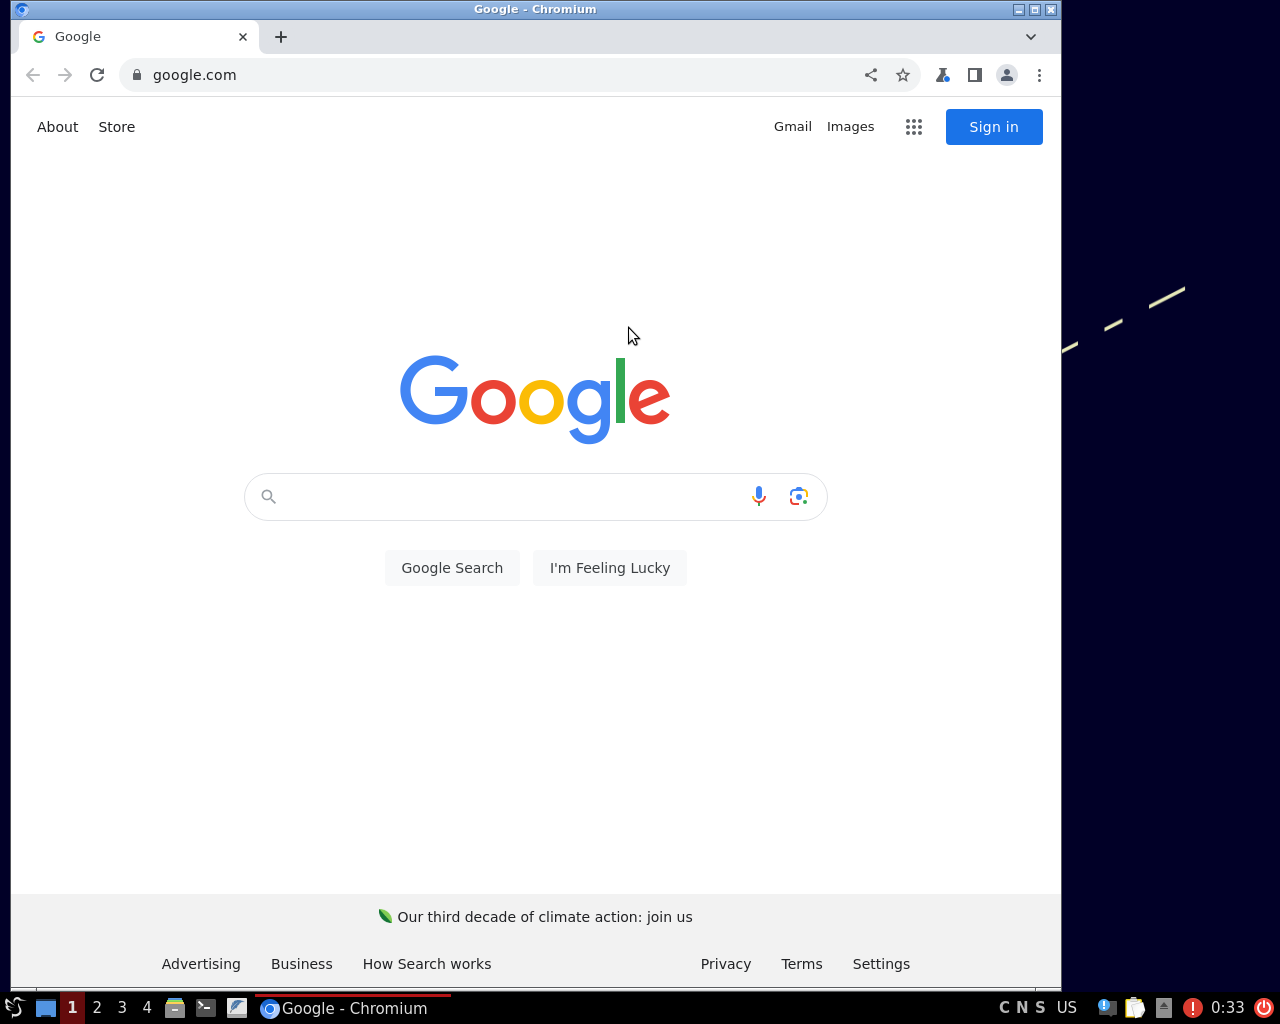

In [19]:
msgs

In [20]:
response = chat(msgs)
response

{'role': 'assistant',
 'content': 'To begin the search for types of Canadian ducks, the next step is to move'}

In [ ]:
msgs.append(response)

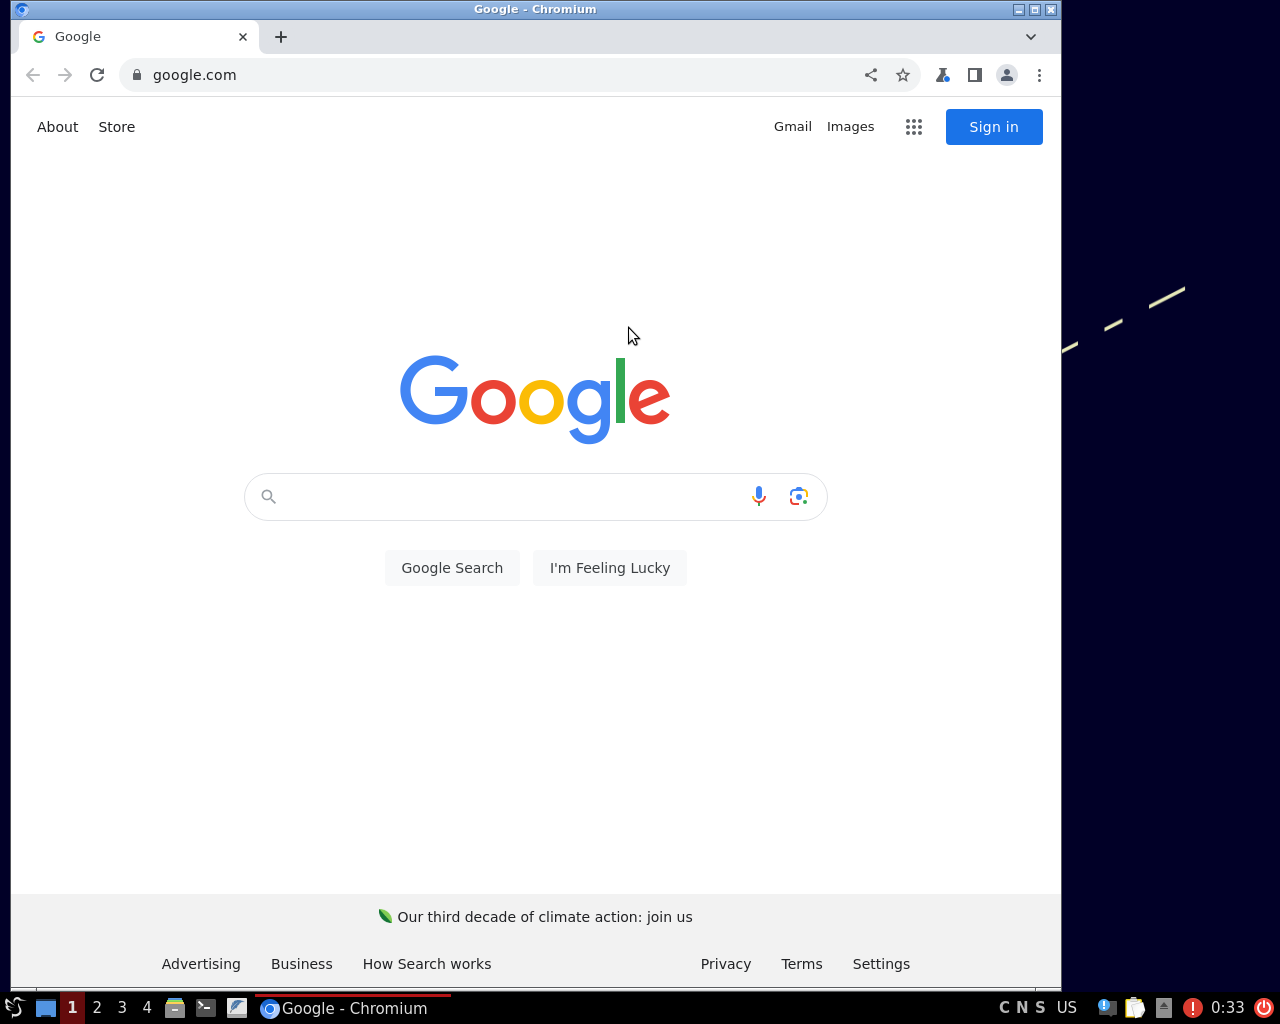

In [22]:


visualize_b64_img(b64_img)